In [5]:
import os
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import custom_tools
import anndata as ad
from tqdm import tqdm
import seaborn as sns
# import decoupler as dc
import plotting
from pathlib import Path
from matplotlib import rcParams
import matplotlib.pyplot as plt
from dataset import TissueDataset
from pathlib import Path
import matplotlib


warnings.simplefilter(action='ignore')
sc.settings.verbosity = 0
# Set figure params
sc.set_figure_params(scanpy=True, facecolor="white", dpi=80, dpi_save=300)


In [6]:

exp_name = "METABRIC"
dataset_name = "METABRIC"
job_id = "METABRIC"
PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")
RAW_DATA_PATH = os.path.join("../data", f"{dataset_name}/raw")
plotting.visualize_clinical_data(plt_path=PLT_PATH)

# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

# Read the explanations adata
adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/{dataset_name}/{exp_name}_{job_id}_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

GPU is available on this device!
Clinical data columns:  Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed',
       'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Tumor Stage', 'Patient's Vital Statu

Seed set to 42
Seed set to 42


Target prediction: OSmonth


<Figure size 640x480 with 0 Axes>

In [7]:
def classify_breast_cancer(row):
    er = row['ER Status']
    pr = row['PR Status']
    her2 = row['HER2 Status']
    
    hr_positive = (er == 'Positive') or (pr == 'Positive')

    if not hr_positive and her2 == 'Negative':
        return 'TripleNeg'
    elif not hr_positive and her2 == 'Positive':
        return 'HR-HER2+'
    elif hr_positive and her2 == 'Negative':
        return 'HR+HER2-'
    elif hr_positive and her2 == 'Positive':
        return 'HR+HER2+'
    else:
        return np.nan  # In case of unexpected values

c_data  = pd.read_csv("../data/METABRIC/brca_metabric_clinical_data.tsv", sep="\t", index_col=False)
s_c_data = pd.read_csv("../data/METABRIC/single_cell_data.csv", index_col=False)
c_data.columns = c_data.columns.str.strip()
c_data['Subtype'] = c_data.apply(classify_breast_cancer, axis=1)
# Print columns
print("Clinical data columns: ", c_data.columns)
print("Single cell data columns: ", s_c_data.columns)

# Keep rows in c_data with PIDs in single_cell_data
c_data = c_data[c_data["Patient ID"].isin(s_c_data["metabricId"])]

# Define custom order
custom_order = ["TripleNeg", "HR-HER2+", "HR+HER2-", "HR+HER2+"]


Clinical data columns:  Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed',
       'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Tumor Stage', 'Patient's Vital Status', 'Subtype'],
      dtype='obje

In [8]:
c_data  = pd.read_csv("../data/METABRIC/brca_metabric_clinical_data.tsv", sep="\t", index_col=False)
analysis_vars  = ['CK19', 'CK8_18', 'CD68', 'SMA',
       'Vimentin', 'HER2', 'CD3', 'Slug', 'ER',
       'PR', 'CD45', 'GATA3', 'CD20', 'Beta_catenin',
       'CAIX', 'Ki67', 'EGFR', 'CK7', 'panCK',
       'CK5', 'Fibronectin']

adata_exp = adata_exp[:, analysis_vars]
imp_threshold = 0.75
# Get the importance of the nodes
node_importance = np.array(adata_exp.obs["importance"])
node_imp_thr = np.quantile(node_importance, imp_threshold)

importances_hard_v2 = np.array(node_importance > node_imp_thr, dtype="str")
# print("importances_hard", importances_hard)
importances_hard_v2 = pd.Series(importances_hard_v2, dtype="category")
# print(importances_hard)
adata_exp.obs["importance_hard"] = importances_hard_v2.values
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst= [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    # print(data.tumor_grade)
    tumor_grade_lst.append(str(data.tumor_grade[0]))
    # print(data.is_censored)
    censor_lst.append(data.is_censored[0].item())
embedding_arr.shape

adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
new_res_param = 0.1
sc.tl.leiden(adata_emb, restrict_to=('leiden', ["1"]),  resolution=new_res_param, key_added='leiden_clust')

adata_emb.obs['leiden_clust'][adata_emb.obs['leiden_clust'].isin(['1,1', '1,0', '2'])]='1,0'
adata_emb.obs['leiden_clust']=adata_emb.obs['leiden_clust'].astype('str').astype('category')
### Reorder and rename the Leiden
adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str')) #, inplace=True)

new_res_param = 0.1
sc.tl.leiden(adata_emb, restrict_to=('leiden_clust', ["0"]),  resolution=new_res_param, key_added='leiden_clust')

adata_emb.obs['leiden_clust'][adata_emb.obs['leiden_clust'].isin(['1,1', '1,0', '2'])]='1,0'
### Reorder and rename the Leiden

adata_emb.obs['leiden_clust'] = adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str')) #, inplace=True)

adata_emb.obs['leiden_clust'][adata_emb.obs['leiden_clust'].isin(['0', '1'])]='1'
adata_emb.obs['leiden_clust']=adata_emb.obs['leiden_clust'].astype('str').astype('category')
### Reorder and rename the Leiden
adata_emb.obs['leiden_clust'] = adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str')) #, inplace=True)s


# subclustering 1
sc.tl.leiden(adata_emb, restrict_to=('leiden_clust', ["1"]),  resolution=new_res_param, key_added='leiden_clust')
adata_emb.obs['leiden_clust']=adata_emb.obs['leiden_clust'].astype('str').astype('category')
### Reorder and rename the Leiden
adata_emb.obs['leiden_clust'] = adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str'))

# subclustering 1
sc.tl.leiden(adata_emb, restrict_to=('leiden_clust', ["3"]),  resolution=new_res_param, key_added='leiden_clust')
adata_emb.obs['leiden_clust']=adata_emb.obs['leiden_clust'].astype('str').astype('category')
### Reorder and rename the Leiden
adata_emb.obs['leiden_clust'] = adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str'))

adata_emb.obs['leiden_clust'][adata_emb.obs['leiden_clust'].isin(['3', '5'])]='3'
adata_emb.obs['leiden_clust']=adata_emb.obs['leiden_clust'].astype('str').astype('category')
adata_emb.obs['leiden_clust'] = adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str'))


adata_emb.obs['leiden_clust'][adata_emb.obs['leiden_clust'].isin(['4', '2', '1'])]='1'
adata_emb.obs['leiden_clust']=adata_emb.obs['leiden_clust'].astype('str').astype('category')
adata_emb.obs['leiden_clust'] = adata_emb.obs['leiden_clust'].cat.rename_categories(np.arange(len(np.unique(adata_emb.obs['leiden_clust']))).astype('str'))

sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"





0 0
1 1
2 2


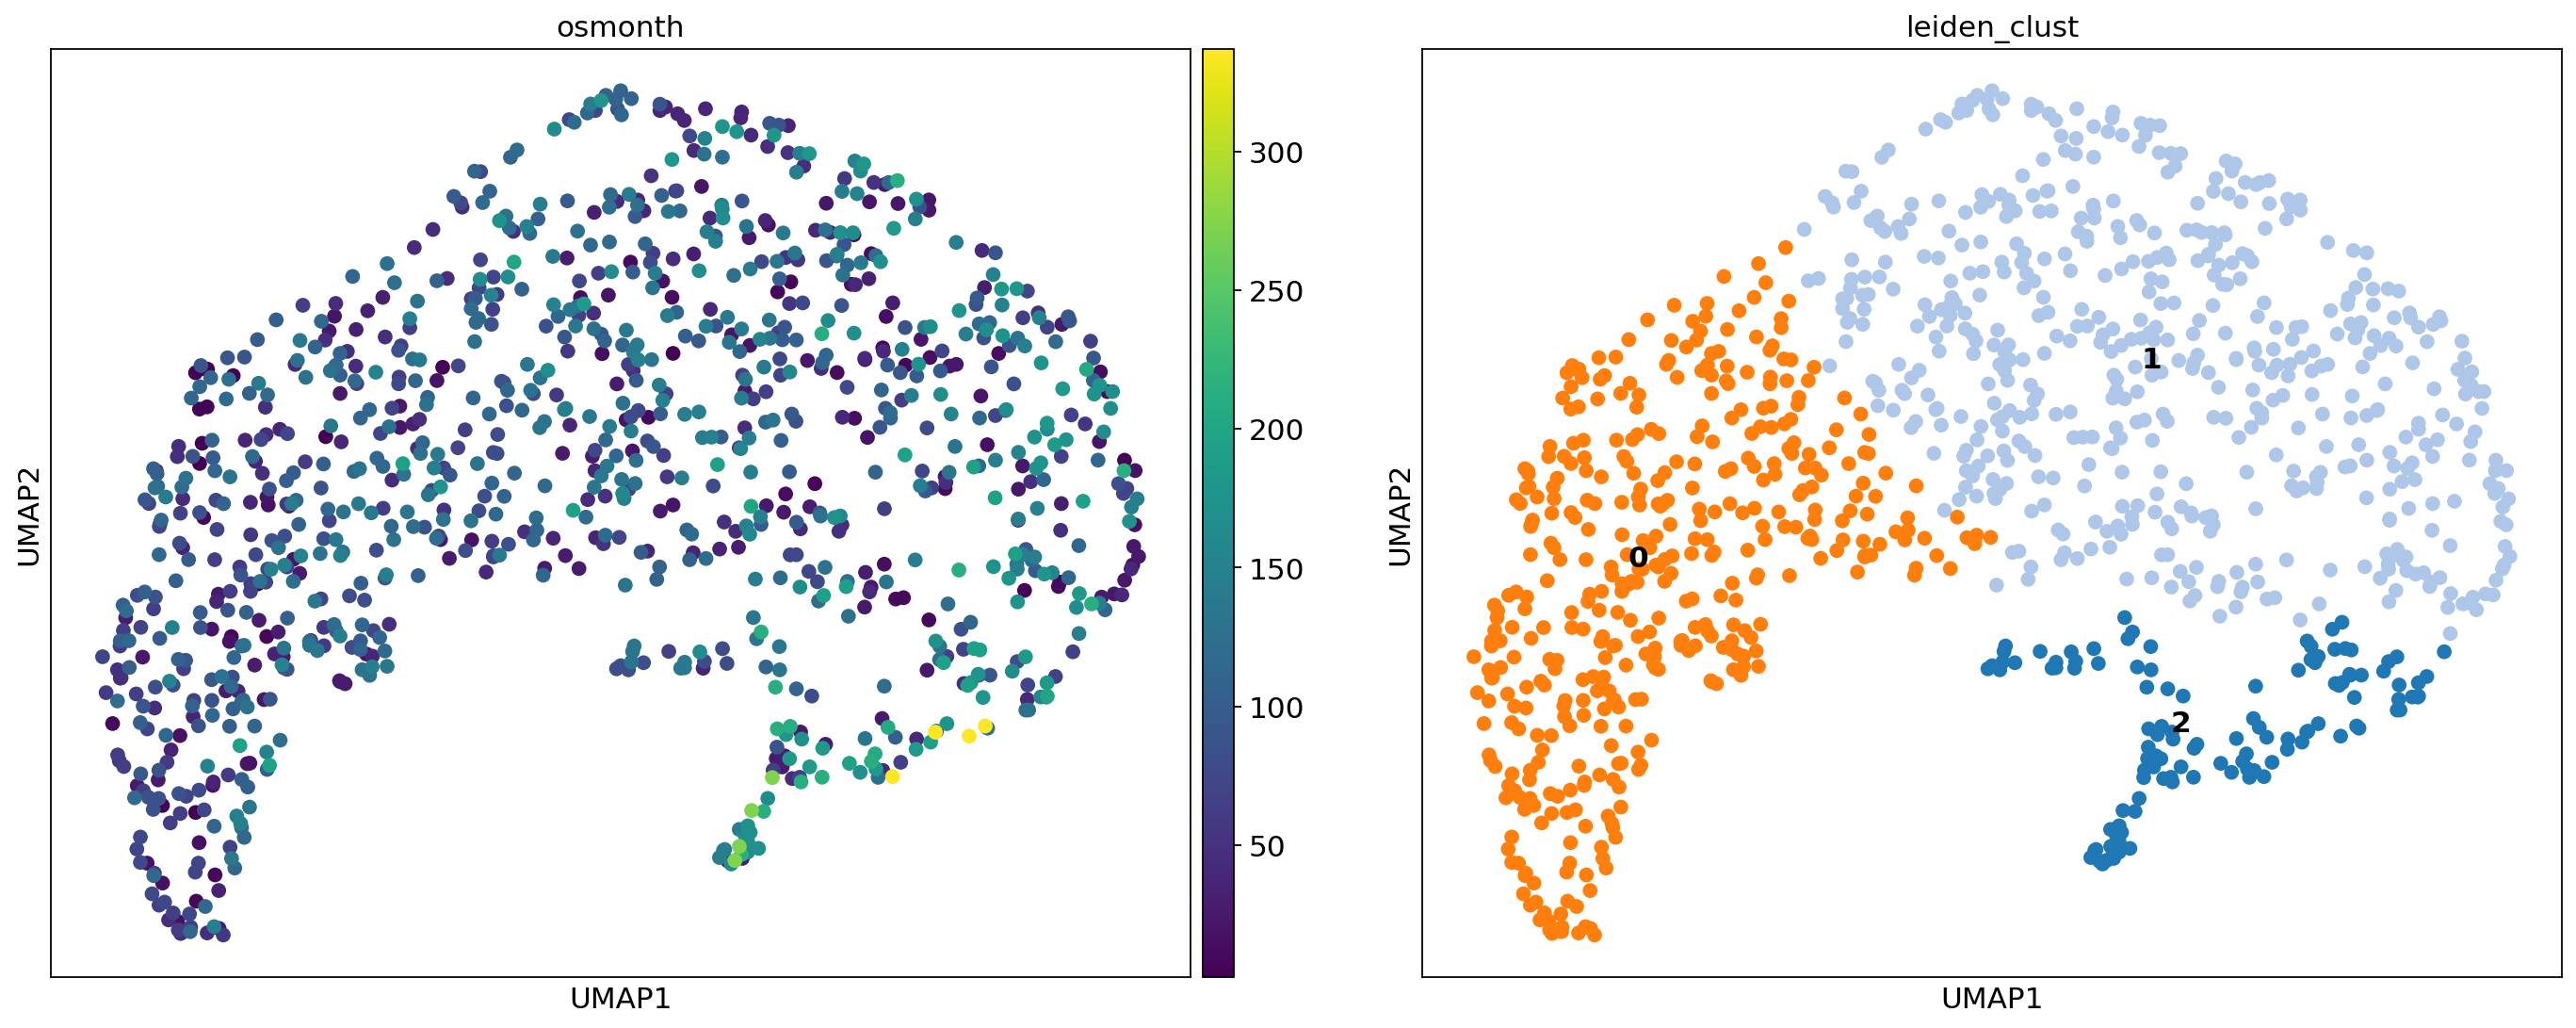

In [9]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden_clust"].cat.categories):
    print(clust_index, ind)
    color_dict[str(len(adata_emb.obs["leiden_clust"].cat.categories)-int(clust_index)-1)] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb, color=["osmonth", "leiden_clust"], size = 200, palette=color_dict,show=False, legend_loc = 'on data')
plt.tight_layout()


In [10]:
cell_type_classification = {
    # --- Stromal cells ---
    'Fibroblasts': 'Stroma',
    'Fibroblasts CD68+': 'Stroma',
    'Myofibroblasts': 'Stroma',
    'Endothelial': 'Stroma',
    'Vascular SMA+': 'Stroma',
    'Myoepithelial': 'Stroma',

    # --- Immune cells ---
    'T cells': 'Immune',
    'B cells': 'Immune',
    'Macrophages Vim+ Slug+': 'Immune',
    'Macrophages Vim+ Slug-': 'Immune',
    'Macrophages Vim+ CD45low': 'Immune',

    # --- Tumor cells ---
    'HR- CKlow CK5+': 'Tumor',
    'HR- CK7-': 'Tumor',
    'Basal CKlow': 'Tumor',
    'HRlow CKlow': 'Tumor',
    'HR+ CK7-': 'Tumor',
    'HR+ CK7- Ki67+': 'Tumor',
    'HR- CK7+': 'Tumor',
    'HER2+': 'Tumor',
    'HR- Ki67+': 'Tumor',
    'HR+ CK7- Slug+': 'Tumor',

    # --- Other / unclear ---
    'Hypoxia': 'Hypoxic'  # could represent a tumor cell state, but not a distinct lineage
}
adata_exp.obs

,clinical_type,img_id,p_id,tumor_grade,osmonth,importance,importance_hard,cell_type
0,HR+HER2-,272,MB-0241,3.0,73.133333,0.080667,False,Vascular SMA+
1,HR+HER2-,272,MB-0241,3.0,73.133333,0.091866,False,Fibroblasts
2,HR+HER2-,272,MB-0241,3.0,73.133333,0.068642,False,Myofibroblasts
3,HR+HER2-,272,MB-0241,3.0,73.133333,0.098027,False,Myofibroblasts
4,HR+HER2-,272,MB-0241,3.0,73.133333,0.101120,False,Fibroblasts
...,...,...,...,...,...,...,...,...
264-863,HR+HER2-,34ul,MB-0178,3.0,104.466667,0.231386,True,HR+ CK7-
265-860,HR+HER2-,34ul,MB-0178,3.0,104.466667,0.240870,True,Fibroblasts
266-857,HR+HER2-,34ul,MB-0178,3.0,104.466667,0.222845,True,HRlow CKlow
267-856,HR+HER2-,34ul,MB-0178,3.0,104.466667,0.262371,True,Fibroblasts CD68+


In [11]:
# Add 'class' column to adata_exp.obs based on cell_type_classification dictionary
adata_exp.obs['class'] = adata_exp.obs['cell_type'].map(cell_type_classification)

# Check the result
print("Class distribution:")
print(adata_exp.obs['class'].value_counts())
print("\nFirst few rows:")
print(adata_exp.obs[['cell_type', 'class']].head(10))


Class distribution:
class
Tumor      239458
Stroma     125362
Immune      36109
Hypoxic      3422
Name: count, dtype: int64

First few rows:
           cell_type   class
0      Vascular SMA+  Stroma
1        Fibroblasts  Stroma
2     Myofibroblasts  Stroma
3     Myofibroblasts  Stroma
4        Fibroblasts  Stroma
5      Vascular SMA+  Stroma
6        Fibroblasts  Stroma
7     Myofibroblasts  Stroma
8     Myofibroblasts  Stroma
9  Fibroblasts CD68+  Stroma


In [12]:
import pandas as pd
import pickle
from scipy.stats import chi2_contingency, fisher_exact
count=0
df_list = []
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    # Convert coordinates array to a dataframe
    coords_df = pd.DataFrame(coordinates_arr, columns=['X', 'Y'])
    # print(coords_df.shape)
    df = tmp_adata_exp.obs.copy()
    
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x) #, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    # print(df.shape)
    # add coordinates
    df = pd.concat([df, coords_df], axis=1)
    
    
    from scipy.spatial.distance import cdist

    # Assuming df has columns 'x', 'y' for region coordinates
    tumor_centroids = df[df["class"] == "Tumor"][["X", "Y"]].values
    stromal_immune_points = df[df["class"].isin(["Vessel", "Stroma", "Immune"])][["X", "Y"]].values

    # Compute minimum distance from each stromal/immune point to tumor points
    distances = cdist(stromal_immune_points, tumor_centroids, metric='euclidean')
    min_distances = distances.min(axis=1)
    # print(min_distances.shape)

    # Define a threshold (e.g., 50 pixels) to classify as peripheral
    df.loc[df["class"].isin(["Vessel", "Stroma", "Immune"]), "region_type"] = ["Peritumoural" if d < 30 else "Extratumoural" for d in min_distances]
    df.loc[df["class"].isin(["Tumor"]), "region_type"] = "Tumor"
    test_graph.region_type = df["region_type"].values
    
    
    # Subset only important regions
    important_df = df[df["importance_hard"] == "True"]
    # Compute the fraction of important regions that are Tumor
    tumor_fraction_in_important = (important_df["class"] == "Tumor").mean()
    df_list.append(df)
    
        
df_concat = pd.concat(df_list, ignore_index=True)         


100%|██████████| 1078/1078 [00:06<00:00, 173.81it/s]


In [13]:
# Add leiden cluster information to df_concat based on img_id
leiden_mapping = adata_emb.obs[['img_id', 'leiden_clust']].drop_duplicates().set_index('img_id')['leiden_clust']
df_concat['leiden_clust'] = df_concat['img_id'].map(leiden_mapping)
df_concat['leiden_clust'].head()

0    1
1    1
2    1
3    1
4    1
Name: leiden_clust, dtype: category
Categories (3, object): ['0', '1', '2']

region_type
Tumor            59.422483
Peritumoural     29.275483
Extratumoural    10.224755
nan               1.077279
Name: proportion, dtype: float64


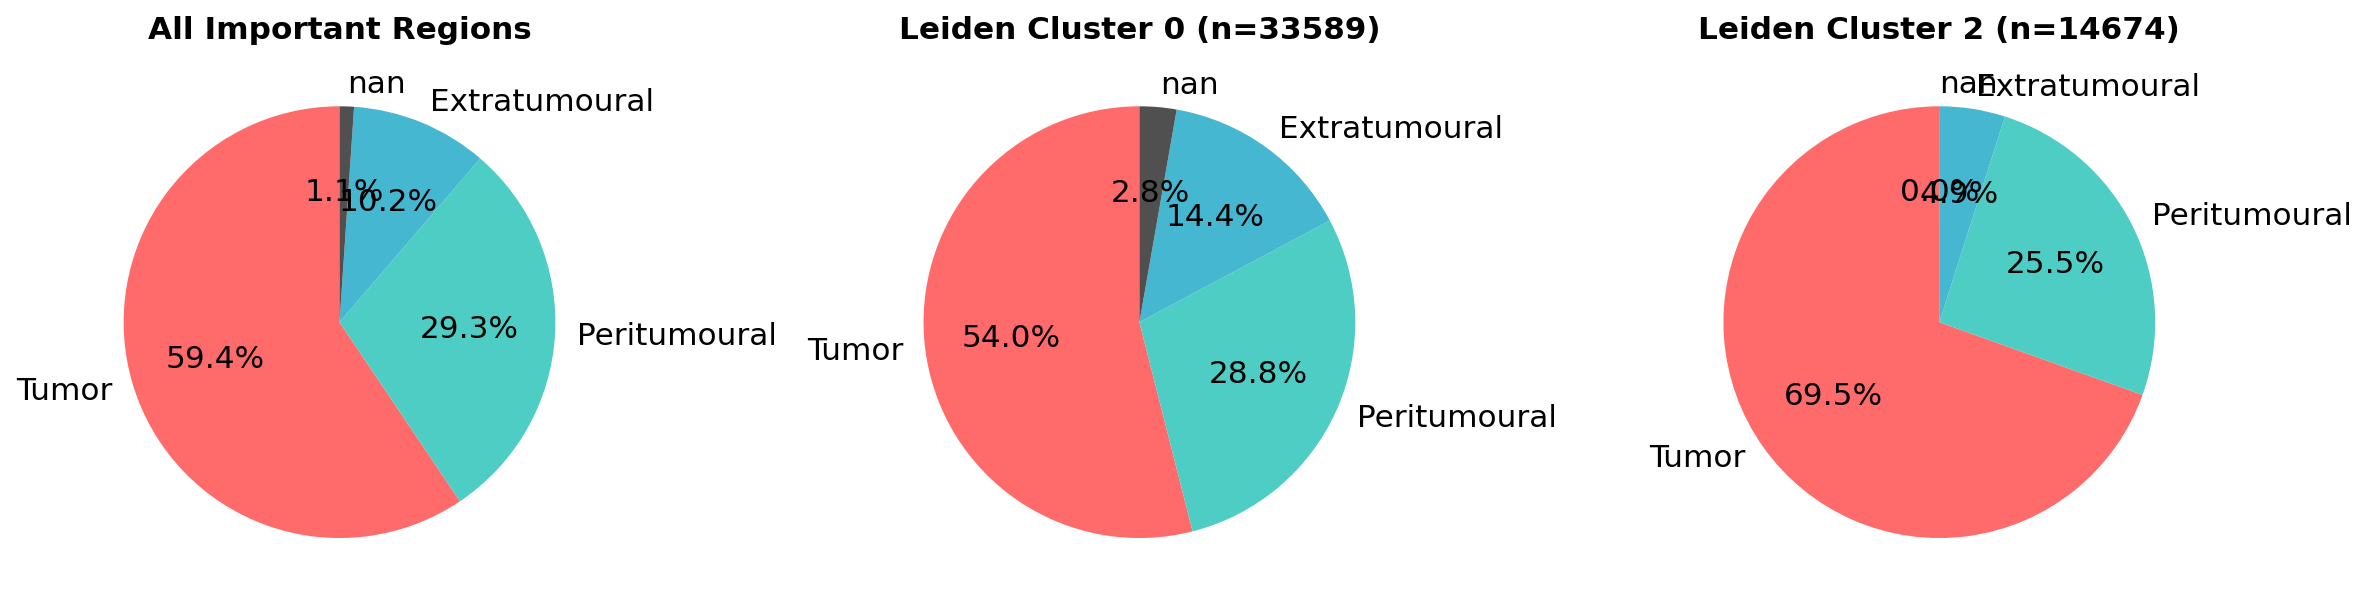

Binomial Test p-value: 1.0000


In [14]:
# Filter only important regions
df_important = df_concat[df_concat["importance_hard"] == "True"]

# Count occurrences of region types
region_counts = df_important["region_type"].value_counts(normalize=True) * 100

# Display results
print(region_counts)


import matplotlib.pyplot as plt


# Create three pie charts: overall, leiden 0, and leiden 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for region types
colors_map = {"Tumor": "#FF6B6B", "Peritumoural": "#4ECDC4", "Extratumoural": "#45B7D1"}

# Plot 1: Overall distribution (as before)
region_counts_all = df_important["region_type"].value_counts(normalize=True) * 100
colors_all = [colors_map.get(region, "#505050") for region in region_counts_all.index]
axes[0].pie(region_counts_all, labels=region_counts_all.index, autopct="%1.1f%%", colors=colors_all, startangle=90)
axes[0].set_title("All Important Regions", fontsize=14, fontweight='bold')

# Plot 2: Leiden cluster 0
df_important_leiden0 = df_important[df_important["leiden_clust"] == "0"]
if len(df_important_leiden0) > 0:
    region_counts_leiden0 = df_important_leiden0["region_type"].value_counts(normalize=True) * 100
    colors_leiden0 = [colors_map.get(region, "#505050") for region in region_counts_leiden0.index]
    axes[1].pie(region_counts_leiden0, labels=region_counts_leiden0.index, autopct="%1.1f%%", colors=colors_leiden0, startangle=90)
    axes[1].set_title(f"Leiden Cluster 0 (n={len(df_important_leiden0)})", fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No data', ha='center', va='center')
    axes[1].set_title("Leiden Cluster 0", fontsize=14, fontweight='bold')

# Plot 3: Leiden cluster 2
df_important_leiden2 = df_important[df_important["leiden_clust"] == "2"]
if len(df_important_leiden2) > 0:
    region_counts_leiden2 = df_important_leiden2["region_type"].value_counts(normalize=True) * 100
    colors_leiden2 = [colors_map.get(region, "#505050") for region in region_counts_leiden2.index]
    axes[2].pie(region_counts_leiden2, labels=region_counts_leiden2.index, autopct="%1.1f%%", colors=colors_leiden2, startangle=90)
    axes[2].set_title(f"Leiden Cluster 2 (n={len(df_important_leiden2)})", fontsize=14, fontweight='bold')
else:
    axes[2].text(0.5, 0.5, 'No data', ha='center', va='center')
    axes[2].set_title("Leiden Cluster 2", fontsize=14, fontweight='bold')

plt.tight_layout()
# plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/piechart_tumour_peritumoural_extratumoural.pdf", dpi=300)
# plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/piechart_tumour_peritumoural_extratumoural.png", dpi=300)
plt.show()

from scipy.stats import binom_test


n_intratumoural = (df_important["region_type"] == "intratumoural").sum()
n_peripheral = (df_important["region_type"] == "peripheral").sum()

# Perform binomial test (expected proportion = 0.5)
p_val = binom_test(n_intratumoural, n_intratumoural + n_peripheral, p=0.5, alternative="two-sided")

print(f"Binomial Test p-value: {p_val:.4f}")






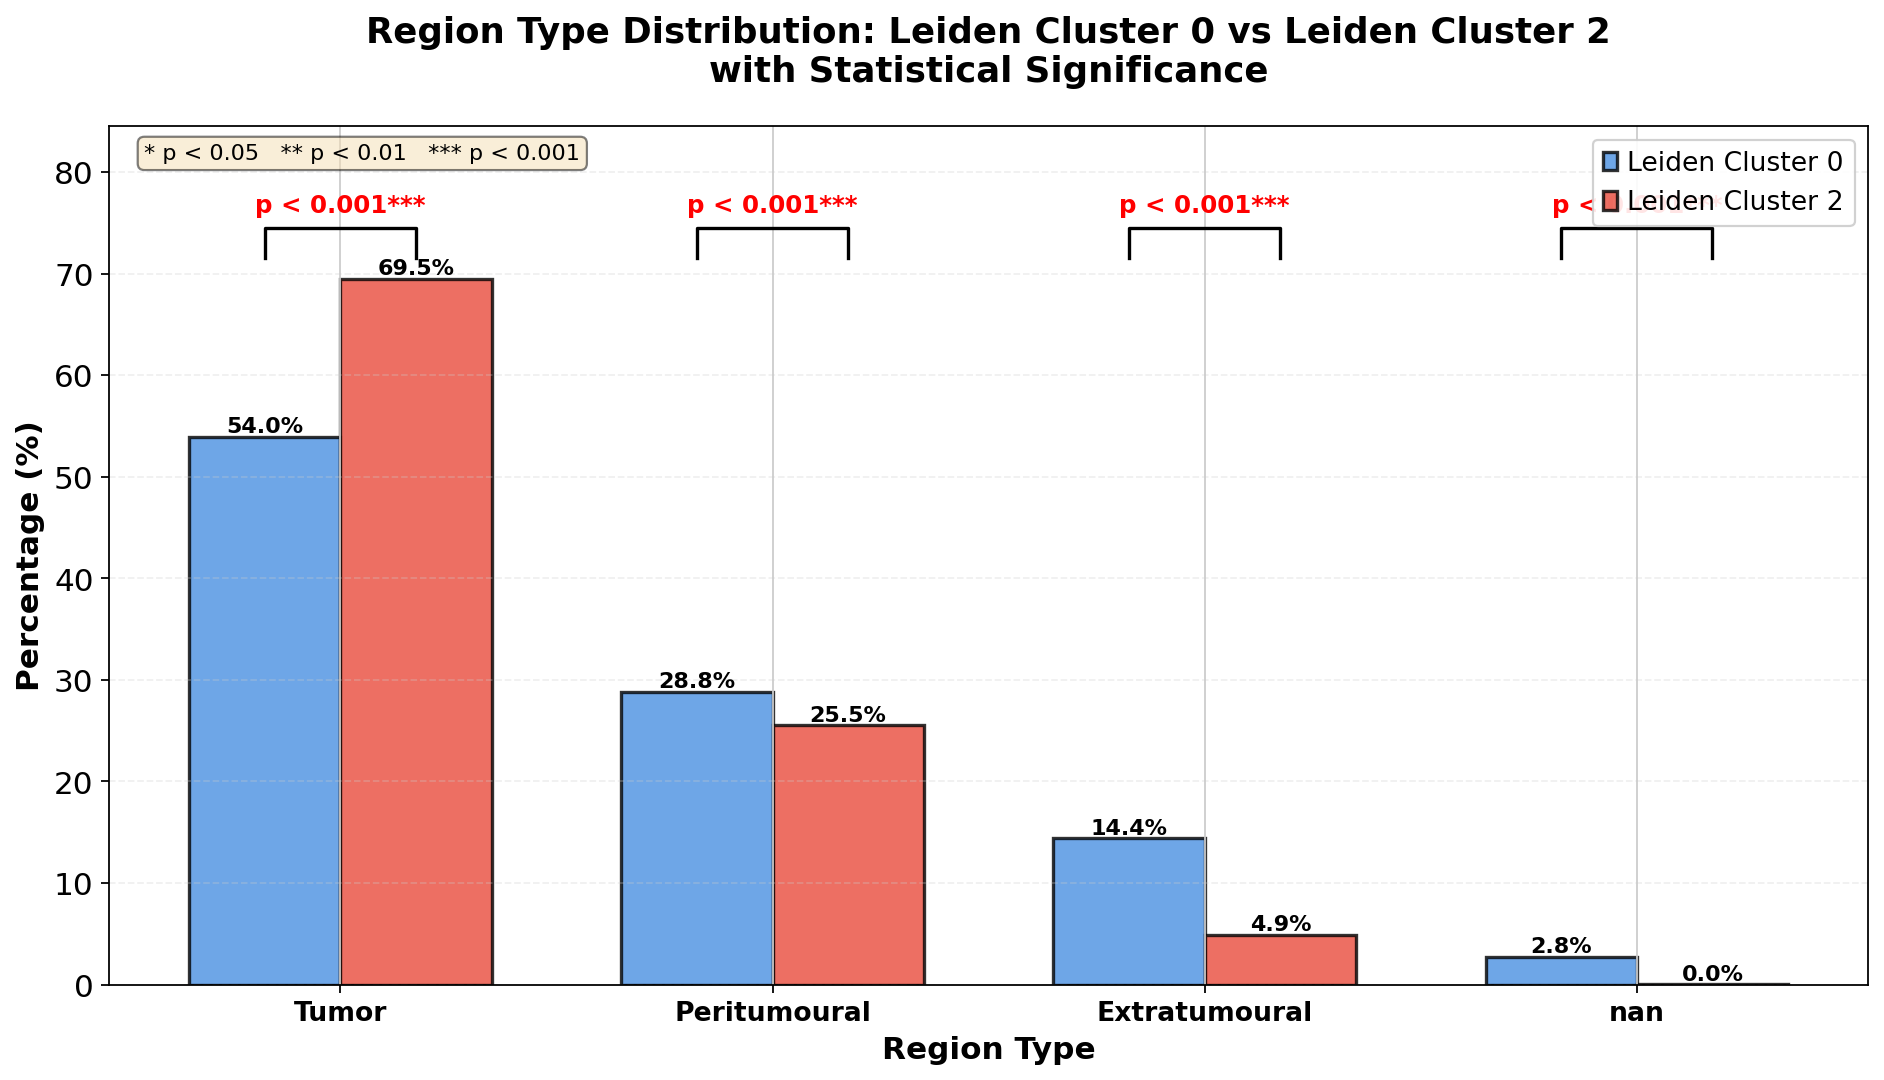


=== Summary Table ===
  Region Type Leiden 0 (%) Leiden 2 (%) Difference (%)     p-value Significant
        Tumor        53.96        69.53         -15.57 5.3708e-224         Yes
 Peritumoural        28.84        25.55           3.29  1.1654e-13         Yes
Extratumoural        14.43         4.90           9.53 8.0050e-200         Yes
          nan         2.76         0.02           2.74  2.7475e-90         Yes


In [15]:
# Visualize percentage differences with p-values
if len(df_important_leiden0) > 0 and len(df_important_leiden2) > 0:
    import matplotlib.pyplot as plt
    from statsmodels.stats.proportion import proportions_ztest
    
    # Prepare data for plotting
    region_types = df_important["region_type"].unique()
    leiden0_props = []
    leiden2_props = []
    p_values = []
    
    for region in region_types:
        count_leiden0 = (df_important_leiden0["region_type"] == region).sum()
        count_leiden2 = (df_important_leiden2["region_type"] == region).sum()
        total_leiden0 = len(df_important_leiden0)
        total_leiden2 = len(df_important_leiden2)
        
        prop_leiden0 = count_leiden0 / total_leiden0 * 100
        prop_leiden2 = count_leiden2 / total_leiden2 * 100
        
        leiden0_props.append(prop_leiden0)
        leiden2_props.append(prop_leiden2)
        
        # Calculate p-value
        counts = np.array([count_leiden0, count_leiden2])
        nobs = np.array([total_leiden0, total_leiden2])
        z_stat, p_val = proportions_ztest(counts, nobs, alternative='two-sided')
        p_values.append(p_val)
    
    # Create grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(region_types))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, leiden0_props, width, label='Leiden Cluster 0', 
                   color='#4A90E2', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, leiden2_props, width, label='Leiden Cluster 2', 
                   color='#E94B3C', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add percentage labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add p-value annotations
    y_max = max(max(leiden0_props), max(leiden2_props))
    for i, (region, p_val) in enumerate(zip(region_types, p_values)):
        # Position for p-value annotation
        y_pos = y_max + 5
        
        # Format p-value
        if p_val < 0.001:
            p_text = f'p < 0.001***'
        elif p_val < 0.01:
            p_text = f'p = {p_val:.3f}**'
        elif p_val < 0.05:
            p_text = f'p = {p_val:.3f}*'
        else:
            p_text = f'p = {p_val:.3f}'
        
        # Add bracket and p-value
        bracket_height = y_pos
        ax.plot([i - width/2, i - width/2, i + width/2, i + width/2], 
               [y_max + 2, bracket_height, bracket_height, y_max + 2],
               'k-', linewidth=1.5)
        
        ax.text(i, bracket_height + 1, p_text, ha='center', va='bottom', 
               fontsize=11, fontweight='bold',
               color='red' if p_val < 0.05 else 'black')
    
    # Formatting
    ax.set_xlabel('Region Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
    ax.set_title('Region Type Distribution: Leiden Cluster 0 vs Leiden Cluster 2\nwith Statistical Significance', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(region_types, fontsize=12, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
    ax.set_ylim(0, y_max + 15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add note about significance levels
    ax.text(0.02, 0.98, '* p < 0.05   ** p < 0.01   *** p < 0.001', 
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/METABRIC/leiden_cluster_comparison_barplot.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n=== Summary Table ===")
    summary_df = pd.DataFrame({
        'Region Type': region_types,
        'Leiden 0 (%)': [f"{p:.2f}" for p in leiden0_props],
        'Leiden 2 (%)': [f"{p:.2f}" for p in leiden2_props],
        'Difference (%)': [f"{l0-l2:.2f}" for l0, l2 in zip(leiden0_props, leiden2_props)],
        'p-value': [f"{p:.4e}" for p in p_values],
        'Significant': ['Yes' if p < 0.05 else 'No' for p in p_values]
    })
    print(summary_df.to_string(index=False))


In [18]:
print(c_data.columns)

Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed',
       'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Tumor Stage', 'Patient's Vital Status'],
      dtype='object')


Total single cell records: 479844
Records with Subtype info: 406039

Subtype distribution:
Subtype
HR+HER2-     303630
TripleNeg     67083
HR+HER2+      23334
HR-HER2+      11992
Name: count, dtype: int64

HR+HER2- patients: 303630 cells from 297 patients

Survival quartiles:
Lower quartile (25%): 62.63 months
Upper quartile (75%): 132.57 months

Survival group distribution:
survival_group
intermediate    150590
low              76792
high             76248
Name: count, dtype: int64

Cells in extreme survival groups (after removing NaN EGFR): 153040
  High survival: 76248 cells
  Low survival: 76792 cells

EGFR ANALYSIS: HR+HER2- PATIENTS

EGFR Summary Statistics:

High Survival Group (n=76248):
  Mean: 0.3927
  Median: 0.2059
  Std: 1.5806
  Range: [0.0000, 40.4526]

Low Survival Group (n=76792):
  Mean: 0.2397
  Median: 0.2118
  Std: 0.1607
  Range: [0.0000, 3.7930]

Difference in means: -0.1530
Fold change (low/high): 0.6103

--- Mann-Whitney U Test ---
U-statistic: 2988867556.0000


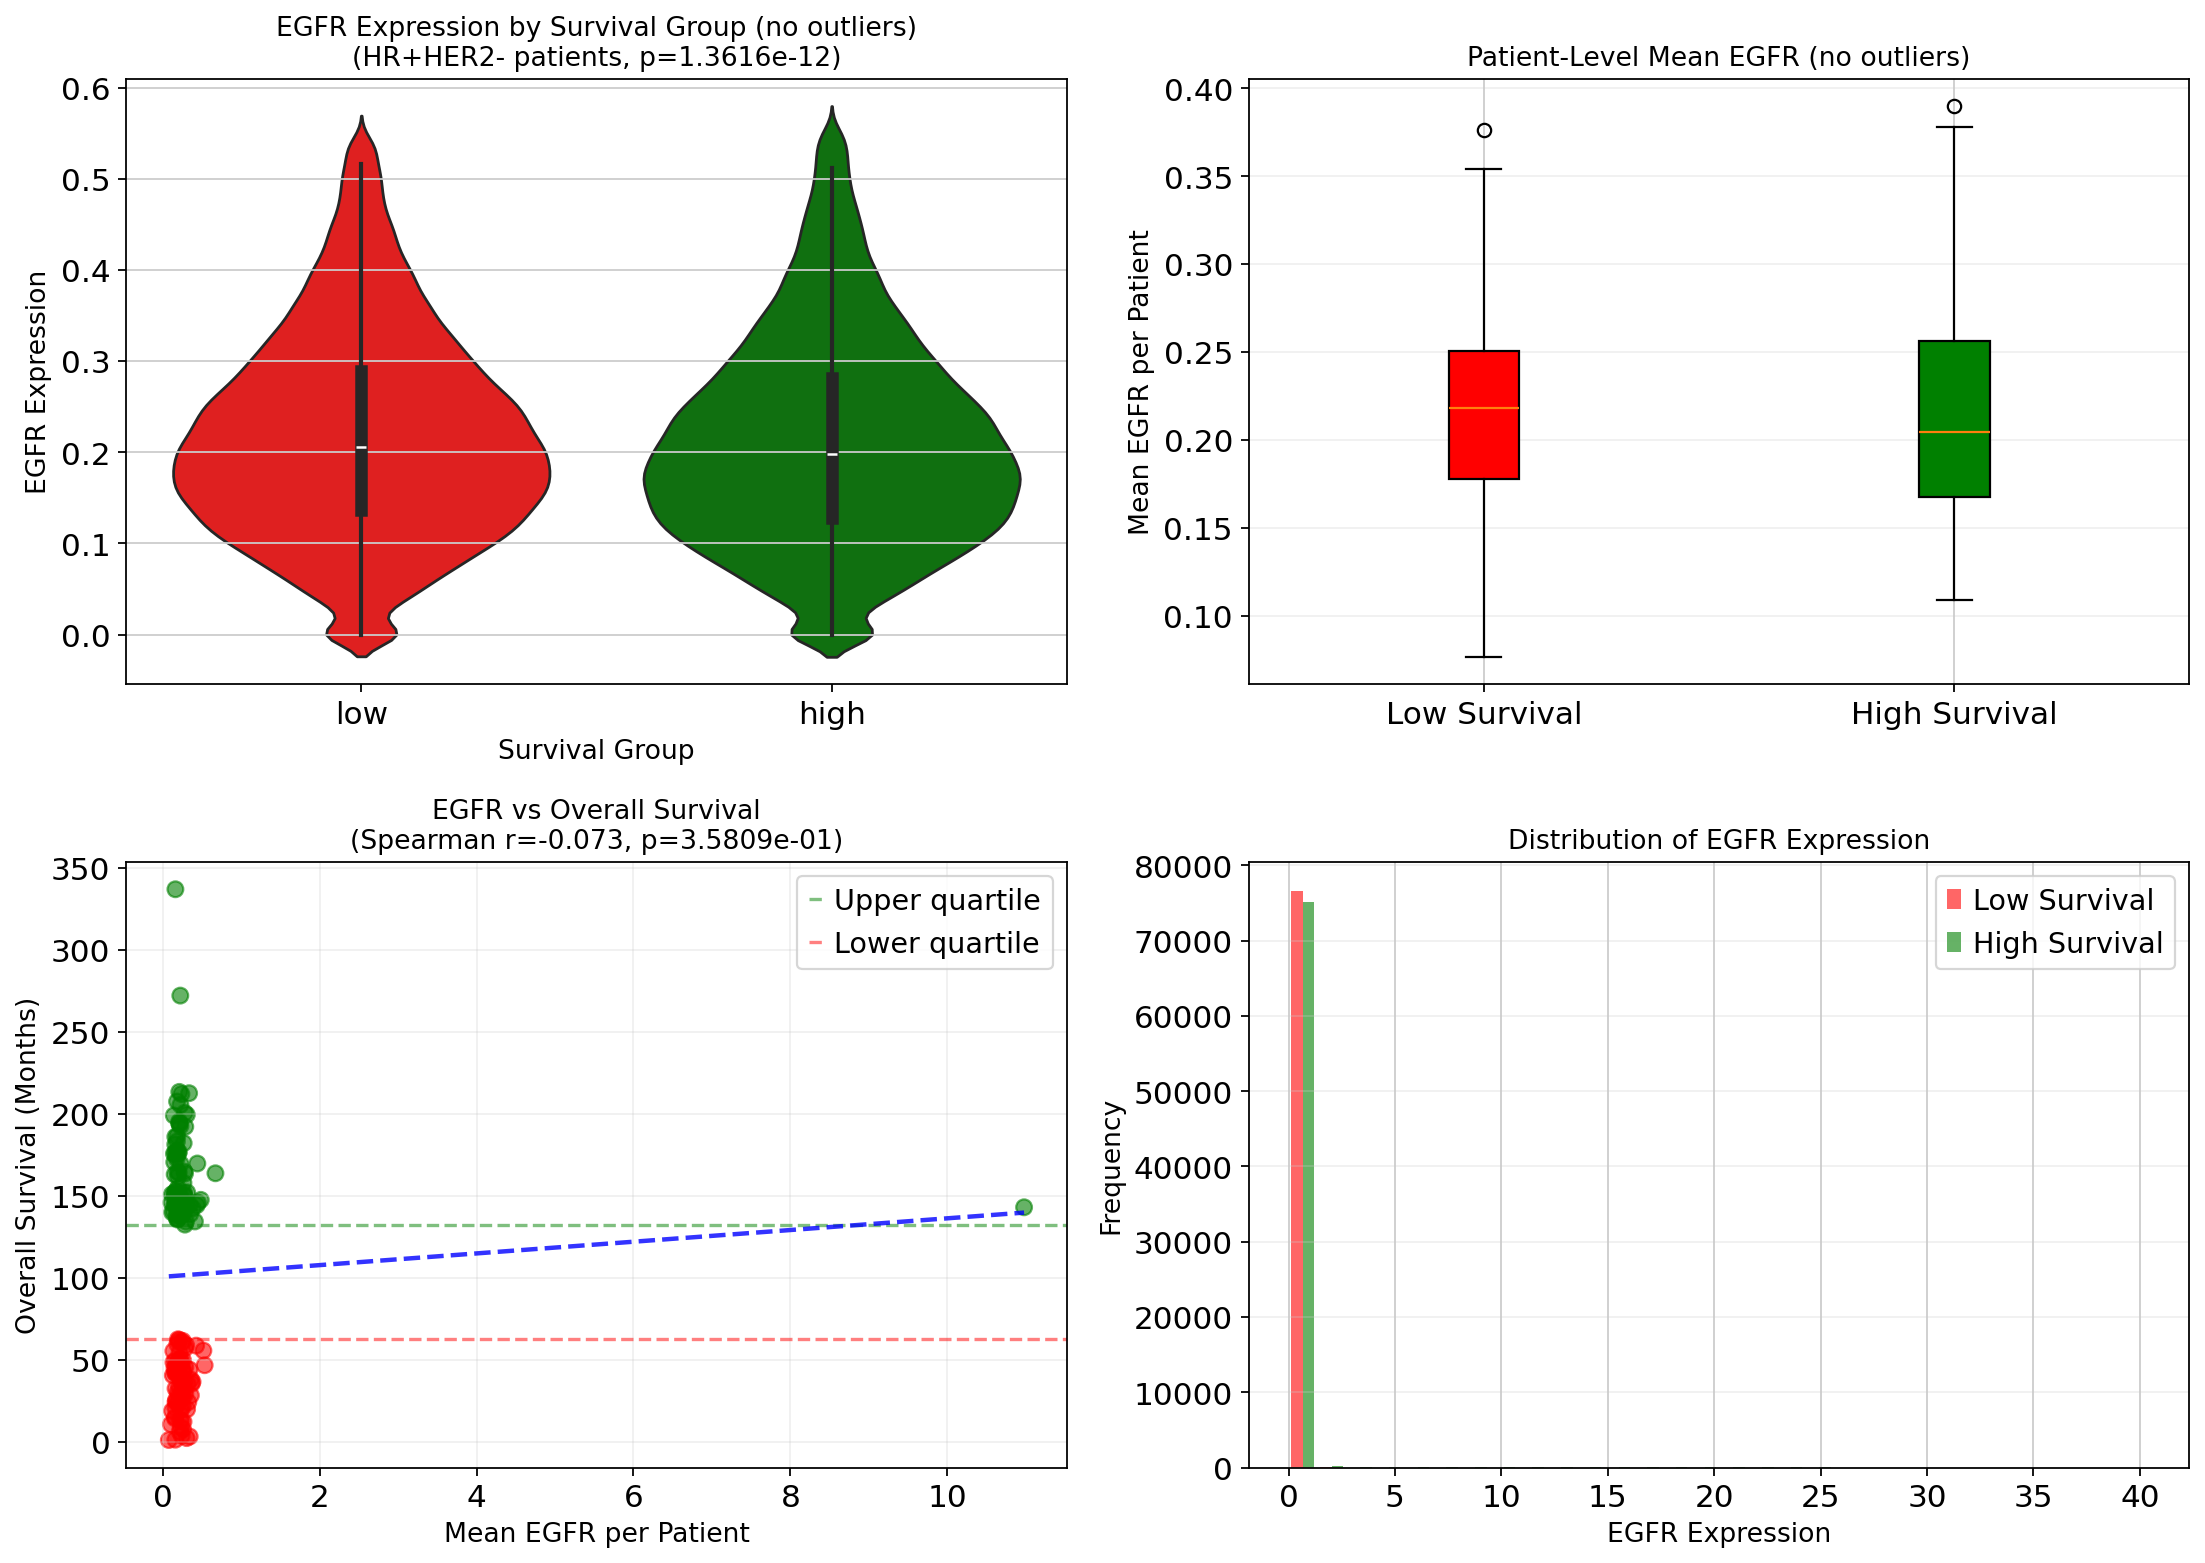

In [22]:
# EGFR correlation analysis for HR+HER2- patients
# Merge c_data with s_c_data to add Subtype and survival information

# First, create a mapping from ImageNumber to Subtype and survival info
c_data_subset = c_data[['Patient ID', 'Subtype', 'Overall Survival (Months)', 'Overall Survival Status']].copy()
c_data_subset.columns = ['metabricId', 'Subtype', 'OSmonth', 'OSstatus']

# Merge with single cell data
s_c_data_merged = s_c_data.merge(c_data_subset, on='metabricId', how='left')

print(f"Total single cell records: {len(s_c_data_merged)}")
print(f"Records with Subtype info: {s_c_data_merged['Subtype'].notna().sum()}")
print(f"\nSubtype distribution:")
print(s_c_data_merged['Subtype'].value_counts())

# Filter for HR+HER2- patients only
s_c_data_hr_her2 = s_c_data_merged[s_c_data_merged['Subtype'] == 'HR+HER2-'].copy()
print(f"\nHR+HER2- patients: {len(s_c_data_hr_her2)} cells from {s_c_data_hr_her2['metabricId'].nunique()} patients")

# Define high and low survival groups based on quartiles
upper_quartile = s_c_data_hr_her2['OSmonth'].quantile(0.75)
lower_quartile = s_c_data_hr_her2['OSmonth'].quantile(0.25)

print(f"\nSurvival quartiles:")
print(f"Lower quartile (25%): {lower_quartile:.2f} months")
print(f"Upper quartile (75%): {upper_quartile:.2f} months")

# Create survival groups
s_c_data_hr_her2['survival_group'] = 'intermediate'
s_c_data_hr_her2.loc[s_c_data_hr_her2['OSmonth'] >= upper_quartile, 'survival_group'] = 'high'
s_c_data_hr_her2.loc[s_c_data_hr_her2['OSmonth'] <= lower_quartile, 'survival_group'] = 'low'

print(f"\nSurvival group distribution:")
print(s_c_data_hr_her2['survival_group'].value_counts())

# Filter for high and low survival groups only and remove NaN EGFR values
s_c_data_extreme = s_c_data_hr_her2[s_c_data_hr_her2['survival_group'].isin(['high', 'low'])].copy()
s_c_data_extreme = s_c_data_extreme[s_c_data_extreme['EGFR'].notna()].copy()

print(f"\nCells in extreme survival groups (after removing NaN EGFR): {len(s_c_data_extreme)}")
print(f"  High survival: {(s_c_data_extreme['survival_group'] == 'high').sum()} cells")
print(f"  Low survival: {(s_c_data_extreme['survival_group'] == 'low').sum()} cells")

# EGFR analysis
print("\n" + "="*60)
print("EGFR ANALYSIS: HR+HER2- PATIENTS")
print("="*60)

# Summary statistics for EGFR (remove NaN values)
egfr_high = s_c_data_extreme[s_c_data_extreme['survival_group'] == 'high']['EGFR'].dropna()
egfr_low = s_c_data_extreme[s_c_data_extreme['survival_group'] == 'low']['EGFR'].dropna()

print(f"\nEGFR Summary Statistics:")
print(f"\nHigh Survival Group (n={len(egfr_high)}):")
print(f"  Mean: {egfr_high.mean():.4f}")
print(f"  Median: {egfr_high.median():.4f}")
print(f"  Std: {egfr_high.std():.4f}")
print(f"  Range: [{egfr_high.min():.4f}, {egfr_high.max():.4f}]")

print(f"\nLow Survival Group (n={len(egfr_low)}):")
print(f"  Mean: {egfr_low.mean():.4f}")
print(f"  Median: {egfr_low.median():.4f}")
print(f"  Std: {egfr_low.std():.4f}")
print(f"  Range: [{egfr_low.min():.4f}, {egfr_low.max():.4f}]")

print(f"\nDifference in means: {egfr_low.mean() - egfr_high.mean():.4f}")
print(f"Fold change (low/high): {egfr_low.mean() / egfr_high.mean():.4f}")

# Statistical tests
from scipy import stats

# Mann-Whitney U test (non-parametric)
u_stat, p_val_mw = stats.mannwhitneyu(egfr_low, egfr_high, alternative='two-sided')
print(f"\n--- Mann-Whitney U Test ---")
print(f"U-statistic: {u_stat:.4f}")
print(f"p-value: {p_val_mw:.4e}")

if p_val_mw < 0.05:
    direction = "higher" if egfr_low.mean() > egfr_high.mean() else "lower"
    print(f"✓ EGFR is significantly {direction} in low survival patients (p < 0.05)")
else:
    print(f"✗ No significant difference (p ≥ 0.05)")

# T-test (parametric)
t_stat, p_val_t = stats.ttest_ind(egfr_low, egfr_high)
print(f"\n--- Independent t-test ---")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val_t:.4e}")

# Correlation analysis at patient level
print("\n" + "="*60)
print("PATIENT-LEVEL CORRELATION ANALYSIS")
print("="*60)

# Aggregate EGFR by patient (NaNs already filtered above)
patient_egfr = s_c_data_extreme.groupby('metabricId').agg({
    'EGFR': 'mean',
    'OSmonth': 'first',
    'survival_group': 'first'
}).reset_index()

# Remove any patients with NaN EGFR (if any remain after aggregation)
patient_egfr = patient_egfr[patient_egfr['EGFR'].notna()].copy()

print(f"\nNumber of patients: {len(patient_egfr)}")
print(f"  High survival: {(patient_egfr['survival_group'] == 'high').sum()}")
print(f"  Low survival: {(patient_egfr['survival_group'] == 'low').sum()}")

# Correlation between mean EGFR and overall survival
corr_pearson, p_pearson = stats.pearsonr(patient_egfr['EGFR'], patient_egfr['OSmonth'])
corr_spearman, p_spearman = stats.spearmanr(patient_egfr['EGFR'], patient_egfr['OSmonth'])

print(f"\n--- Correlation: EGFR vs Overall Survival ---")
print(f"Pearson correlation: {corr_pearson:.4f} (p={p_pearson:.4e})")
print(f"Spearman correlation: {corr_spearman:.4f} (p={p_spearman:.4e})")

if p_pearson < 0.05:
    if corr_pearson < 0:
        print(f"✓ Negative correlation: Higher EGFR associated with lower survival (p < 0.05)")
    else:
        print(f"✓ Positive correlation: Higher EGFR associated with higher survival (p < 0.05)")
else:
    print(f"✗ No significant correlation (p ≥ 0.05)")

# Remove outliers for violin plot using IQR method
def remove_outliers_iqr(data, column, group_column):
    """Remove outliers using IQR method for each group"""
    df_clean = pd.DataFrame()
    for group in data[group_column].unique():
        group_data = data[data[group_column] == group].copy()
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group_clean = group_data[(group_data[column] >= lower_bound) & (group_data[column] <= upper_bound)]
        df_clean = pd.concat([df_clean, group_clean])
    return df_clean

s_c_data_extreme_no_outliers = remove_outliers_iqr(s_c_data_extreme, 'EGFR', 'survival_group')
print(f"\nAfter removing outliers: {len(s_c_data_extreme_no_outliers)} cells")
print(f"  High survival: {(s_c_data_extreme_no_outliers['survival_group'] == 'high').sum()} cells")
print(f"  Low survival: {(s_c_data_extreme_no_outliers['survival_group'] == 'low').sum()} cells")

# Compare mean EGFR with and without outliers
print("\n" + "="*60)
print("IMPACT OF OUTLIER REMOVAL ON MEAN EGFR EXPRESSION")
print("="*60)

# With outliers
egfr_high_with_outliers = s_c_data_extreme[s_c_data_extreme['survival_group'] == 'high']['EGFR']
egfr_low_with_outliers = s_c_data_extreme[s_c_data_extreme['survival_group'] == 'low']['EGFR']

# Without outliers
egfr_high_no_outliers = s_c_data_extreme_no_outliers[s_c_data_extreme_no_outliers['survival_group'] == 'high']['EGFR']
egfr_low_no_outliers = s_c_data_extreme_no_outliers[s_c_data_extreme_no_outliers['survival_group'] == 'low']['EGFR']

print("\nHigh Survival Group:")
print(f"  Mean with outliers:    {egfr_high_with_outliers.mean():.4f}")
print(f"  Mean without outliers: {egfr_high_no_outliers.mean():.4f}")
print(f"  Difference:            {egfr_high_no_outliers.mean() - egfr_high_with_outliers.mean():.4f}")
print(f"  % Change:              {((egfr_high_no_outliers.mean() - egfr_high_with_outliers.mean()) / egfr_high_with_outliers.mean() * 100):.2f}%")

print("\nLow Survival Group:")
print(f"  Mean with outliers:    {egfr_low_with_outliers.mean():.4f}")
print(f"  Mean without outliers: {egfr_low_no_outliers.mean():.4f}")
print(f"  Difference:            {egfr_low_no_outliers.mean() - egfr_low_with_outliers.mean():.4f}")
print(f"  % Change:              {((egfr_low_no_outliers.mean() - egfr_low_with_outliers.mean()) / egfr_low_with_outliers.mean() * 100):.2f}%")

print("\nDifference between groups:")
print(f"  With outliers (Low - High):    {egfr_low_with_outliers.mean() - egfr_high_with_outliers.mean():.4f}")
print(f"  Without outliers (Low - High): {egfr_low_no_outliers.mean() - egfr_high_no_outliers.mean():.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Violin plot (without outliers)
ax = axes[0, 0]
sns.violinplot(data=s_c_data_extreme_no_outliers, x='survival_group', y='EGFR', 
               order=['low', 'high'], palette={'low': 'red', 'high': 'green'}, ax=ax)
ax.set_xlabel('Survival Group', fontsize=12)
ax.set_ylabel('EGFR Expression', fontsize=12)
ax.set_title(f'EGFR Expression by Survival Group (no outliers)\n(HR+HER2- patients, p={p_val_mw:.4e})', fontsize=12)

# 2. Box plot with individual points (patient-level, without outliers)
# Recalculate patient-level EGFR using data without outliers
patient_egfr_no_outliers = s_c_data_extreme_no_outliers.groupby('metabricId').agg({
    'EGFR': 'mean',
    'OSmonth': 'first',
    'survival_group': 'first'
}).reset_index()

ax = axes[0, 1]
patient_egfr_high_no_outliers = patient_egfr_no_outliers[patient_egfr_no_outliers['survival_group'] == 'high']
patient_egfr_low_no_outliers = patient_egfr_no_outliers[patient_egfr_no_outliers['survival_group'] == 'low']
bp = ax.boxplot([patient_egfr_low_no_outliers['EGFR'], patient_egfr_high_no_outliers['EGFR']], 
                labels=['Low Survival', 'High Survival'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][1].set_facecolor('green')
ax.set_ylabel('Mean EGFR per Patient', fontsize=12)
ax.set_title('Patient-Level Mean EGFR (no outliers)', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# 3. Scatter plot: EGFR vs Overall Survival
ax = axes[1, 0]
scatter = ax.scatter(patient_egfr['EGFR'], patient_egfr['OSmonth'], 
                    c=patient_egfr['survival_group'].map({'low': 'red', 'high': 'green'}),
                    alpha=0.6, s=50)
ax.set_xlabel('Mean EGFR per Patient', fontsize=12)
ax.set_ylabel('Overall Survival (Months)', fontsize=12)
ax.set_title(f'EGFR vs Overall Survival\n(Spearman r={corr_spearman:.3f}, p={p_spearman:.4e})', fontsize=12)
ax.axhline(y=upper_quartile, color='green', linestyle='--', alpha=0.5, label='Upper quartile')
ax.axhline(y=lower_quartile, color='red', linestyle='--', alpha=0.5, label='Lower quartile')
ax.legend()
ax.grid(alpha=0.3)

# Add regression line
z = np.polyfit(patient_egfr['EGFR'], patient_egfr['OSmonth'], 1)
p = np.poly1d(z)
x_line = np.linspace(patient_egfr['EGFR'].min(), patient_egfr['EGFR'].max(), 100)
ax.plot(x_line, p(x_line), "b--", alpha=0.8, linewidth=2)

# 4. Histogram comparison
ax = axes[1, 1]
ax.hist([egfr_low, egfr_high], bins=30, label=['Low Survival', 'High Survival'], 
        color=['red', 'green'], alpha=0.6)
ax.set_xlabel('EGFR Expression', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of EGFR Expression', fontsize=12)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/METABRIC_EGFR_correlation_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
s_c_data = pd.read_csv("../data/METABRIC/single_cell_data.csv", index_col=False)

In [19]:
def classify_breast_cancer(row):
    er = row['ER Status']
    pr = row['PR Status']
    her2 = row['HER2 Status']
    
    hr_positive = (er == 'Positive') or (pr == 'Positive')

    if not hr_positive and her2 == 'Negative':
        return 'TripleNeg'
    elif not hr_positive and her2 == 'Positive':
        return 'HR-HER2+'
    elif hr_positive and her2 == 'Negative':
        return 'HR+HER2-'
    elif hr_positive and her2 == 'Positive':
        return 'HR+HER2+'
    else:
        return np.nan  # In case of unexpected values

c_data  = pd.read_csv("../data/METABRIC/brca_metabric_clinical_data.tsv", sep="\t", index_col=False)
s_c_data = pd.read_csv("../data/METABRIC/single_cell_data.csv", index_col=False)
c_data.columns = c_data.columns.str.strip()
c_data['Subtype'] = c_data.apply(classify_breast_cancer, axis=1)
# Print columns
print("Clinical data columns: ", c_data.columns)
print("Single cell data columns: ", s_c_data.columns)

# Keep rows in c_data with PIDs in single_cell_data
c_data = c_data[c_data["Patient ID"].isin(s_c_data["metabricId"])]

# Define custom order
custom_order = ["TripleNeg", "HR-HER2+", "HR+HER2-", "HR+HER2+"]


Clinical data columns:  Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed',
       'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Tumor Stage', 'Patient's Vital Status', 'Subtype'],
      dtype='obje

In [ ]:
c_data

In [ ]:
s_c_data

In [ ]:
# Visualize percentage differences with p-values
if len(df_important_leiden0) > 0 and len(df_important_leiden2) > 0:
    import matplotlib.pyplot as plt
    from statsmodels.stats.proportion import proportions_ztest
    
    # Prepare data for plotting
    region_types = df_important["region_type"].unique()
    leiden0_props = []
    leiden2_props = []
    p_values = []
    
    for region in region_types:
        count_leiden0 = (df_important_leiden0["region_type"] == region).sum()
        count_leiden2 = (df_important_leiden2["region_type"] == region).sum()
        total_leiden0 = len(df_important_leiden0)
        total_leiden2 = len(df_important_leiden2)
        
        prop_leiden0 = count_leiden0 / total_leiden0 * 100
        prop_leiden2 = count_leiden2 / total_leiden2 * 100
        
        leiden0_props.append(prop_leiden0)
        leiden2_props.append(prop_leiden2)
        
        # Calculate p-value
        counts = np.array([count_leiden0, count_leiden2])
        nobs = np.array([total_leiden0, total_leiden2])
        z_stat, p_val = proportions_ztest(counts, nobs, alternative='two-sided')
        p_values.append(p_val)
    
    # Create grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(region_types))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, leiden0_props, width, label='Leiden Cluster 0', 
                   color='#4A90E2', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, leiden2_props, width, label='Leiden Cluster 2', 
                   color='#E94B3C', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add percentage labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add p-value annotations
    y_max = max(max(leiden0_props), max(leiden2_props))
    for i, (region, p_val) in enumerate(zip(region_types, p_values)):
        # Position for p-value annotation
        y_pos = y_max + 5
        
        # Format p-value
        if p_val < 0.001:
            p_text = f'p < 0.001***'
        elif p_val < 0.01:
            p_text = f'p = {p_val:.3f}**'
        elif p_val < 0.05:
            p_text = f'p = {p_val:.3f}*'
        else:
            p_text = f'p = {p_val:.3f}'
        
        # Add bracket and p-value
        bracket_height = y_pos
        ax.plot([i - width/2, i - width/2, i + width/2, i + width/2], 
               [y_max + 2, bracket_height, bracket_height, y_max + 2],
               'k-', linewidth=1.5)
        
        ax.text(i, bracket_height + 1, p_text, ha='center', va='bottom', 
               fontsize=11, fontweight='bold',
               color='red' if p_val < 0.05 else 'black')
    
    # Formatting
    ax.set_xlabel('Region Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
    ax.set_title('Region Type Distribution: Leiden Cluster 0 vs Leiden Cluster 2\nwith Statistical Significance', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(region_types, fontsize=12, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
    ax.set_ylim(0, y_max + 15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add note about significance levels
    ax.text(0.02, 0.98, '* p < 0.05   ** p < 0.01   *** p < 0.001', 
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/leiden_cluster_comparison_barplot.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/leiden_cluster_comparison_barplot.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n=== Summary Table ===")
    summary_df = pd.DataFrame({
        'Region Type': region_types,
        'Leiden 0 (%)': [f"{p:.2f}" for p in leiden0_props],
        'Leiden 2 (%)': [f"{p:.2f}" for p in leiden2_props],
        'Difference (%)': [f"{l0-l2:.2f}" for l0, l2 in zip(leiden0_props, leiden2_props)],
        'p-value': [f"{p:.4e}" for p in p_values],
        'Significant': ['Yes' if p < 0.05 else 'No' for p in p_values]
    })
    print(summary_df.to_string(index=False))
